# 智能推荐系统第一次作业代码

## Memory-based CF for Rating Prediction

10215001419 宋朝芸

### UCF & ICF with Pearson Correlation

In [6]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [7]:
### 基于用户

#### pearson相关系数矩阵
def pearson_sim_matrix(dat):
  # 用户相似度，需要把用户作为列（转置）
  temp = dat.transpose()
  return temp.corr()


#### 选择最相似的k个用户
def select_neighbor(dat, uid, iid, k, thres, mean, sim):  
  # 获取与用户u相似度大于阈值的用户列表
  neighbors = np.where(sim[uid] > thres)[0]
  
  # 获取对商品i评分过的用户列表及其对应的评分和相似度
  neighbors_info = [(v, dat.iloc[v, iid], sim.iloc[uid, v], mean.iloc[v]) for v in neighbors if not np.isnan(dat.iloc[v, iid])]

  # 根据与用户u的相似度降序排序
  neighbors_info.sort(key=lambda x: x[2], reverse=True)

  # 获取最大的k个相似用户及其对应的dat取值和sim取值
  neighbors_info = neighbors_info[:k]
  if(len(neighbors_info) == 0):
    user = rating = sim = mean = 0
  else:
    user, rating, sim, mean = zip(*neighbors_info)

  return user, rating, sim, mean
  

#### 进行预测
def predict_rate(dat, uid, iid, k, threshold, mean, sim):
  # 计算近邻集合
  _, knn_ratings, knn_sim, knn_mean = select_neighbor(dat, uid, iid, k, threshold, mean, sim)

  # 计算预测值
  pred = mean[uid] + np.sum((np.array(knn_ratings) - np.array(knn_mean)) * np.array(knn_sim)) / (np.sum(knn_sim)+1)

  # 调整为符合要求的取值
  pred = round(pred)
  if(pred > 10):
    pred = 10
  if(pred < 1):
    pred = 1

  return pred


#### 计算验证集RMSE
def RMSE_calculate(train_set, validset, k, threshold):  
  # 计算用户均分和用户相似度矩阵
  mean = train_set.mean(axis = 1, skipna = True)
  sim = pearson_sim_matrix(train_set)

  # 初始化空列表存储非空元素的预测值和真实值
  predicted_values = []
  true_values = []
  # 遍历验证集进行预测
  for row in validset:
    uid, iid, rate = row
    pred = predict_rate(train_set, uid, iid, k, threshold, mean, sim)
    predicted_values.append(pred)
    true_values.append(rate)
  
  # 计算RMSE
  mse = mean_squared_error(true_values, predicted_values)
  rmse = np.sqrt(mse)
  
  return rmse, true_values, predicted_values


#### 读取并划分数据
def load_and_split(train_path, test_path, test_size=0.2, random_state=None, choice = 0):
  # 加载csv数据集为pd数据框
  train = pd.read_csv(train_path)
  test = pd.read_csv(test_path)
  # 转为user-item矩阵
  train_df = train.pivot(index='userid',columns='itemid',values=['rate'])

  # 模型选择步
  if (choice == 0):
    # 加载pd数据框用于surprise包
    reader = Reader(rating_scale=(1, 10))
    load_train = Dataset.load_from_df(train, reader)
    # surprise包进行数据划分
    _, validset = train_test_split(load_train, test_size=test_size, random_state=random_state)

    # train_df - validset = train_set
    # 初始化train_set为user-item矩阵
    train_set = train_df.copy()
    # 遍历validset，更新train_set和valid_df
    for row in validset:
        userid, itemid, rate = row
        # 在train_set中将valid_set中出现的值设为nan
        train_set.iloc[userid, itemid] = float('nan')
    
    return train_set, validset, test
  
  # 结果预测步
  if(choice == 1):
     
     return train_df, test

In [8]:
### 基于物品

#### pearson相关系数
def pearson_sim_matrix_item(dat):
  return dat.corr()

#### 选择最相似的k个物品
def select_neighbor_item(dat, uid, iid, k, thres, mean, sim):  
  # 获取与物品i相似度大于阈值的物品列表
  neighbors = np.where(sim.iloc[iid] > thres)[0]

  # 获取用户u评分过的物品列表及其对应的评分和相似度
  neighbors_info = [(j, dat.iloc[uid, j], sim.iloc[iid, j], mean.iloc[j]) for j in neighbors if not np.isnan(dat.iloc[uid, j])]

  # 根据与物品i的相似度降序排序
  neighbors_info.sort(key=lambda x: x[2], reverse=True)

  # 获取最大的k个相似物品及其对应的评分和相似度
  neighbors_info = neighbors_info[:k]
  if(len(neighbors_info) == 0):
    item = rating = sim = mean = 0
  else:
    item, rating, sim, mean = zip(*neighbors_info)

  return item, rating, sim, mean
  

#### 进行预测
def predict_rate_item(dat, uid, iid, k, threshold, mean, sim):
  # 计算近邻集合
  _, knn_ratings, knn_sim, _ = select_neighbor_item(dat, uid, iid, k, threshold, mean, sim)

  # 计算预测值
  if(np.sum(knn_sim) != 0):
    pred = np.sum((np.array(knn_ratings)) * np.array(knn_sim)) / (np.sum(knn_sim))
  else:
    pred = mean[iid]

  # 调整为符合要求的取值
  pred = round(pred)
  if(pred > 10):
    pred = 10
  if(pred < 1):
    pred = 1
  
  return pred


# 计算验证集上的RMSE
def RMSE_calculate_item(train_set, validset, k, threshold):  
  # 计算物品相似度矩阵
  mean = train_set.mean(axis = 0, skipna = True)
  sim = pearson_sim_matrix_item(train_set)

  # 初始化空列表存储非空元素的预测值和真实值
  predicted_values = []
  true_values = []
  # 遍历验证集进行预测
  for row in validset:
    uid, iid, rate = row
    pred = predict_rate_item(train_set, uid, iid, k, threshold, mean, sim)
    predicted_values.append(pred)
    true_values.append(rate)
  
  # 计算RMSE
  mse = mean_squared_error(true_values, predicted_values)
  rmse = np.sqrt(mse)
  
  return rmse, true_values, predicted_values

In [9]:
### 参数搜索

##### 基于用户
def search_rmse(train, valid, ks, thresholds):
  # 初始化RMSE矩阵为空矩阵
  RMSE_out = []
  # 遍历参数列表计算RMSE
  for k in ks:
    RMSE_in = []
    for thres in thresholds:
      rmse, _, _ = RMSE_calculate(train, valid, k, thres)
      RMSE_in.append(rmse)
    RMSE_out.append(RMSE_in)

  return RMSE_out


##### 基于物品
def search_rmse_item(train, valid, ks, thresholds):
  # 初始化RMSE矩阵为空矩阵
  RMSE_out = []
  # 遍历参数列表计算RMSE
  for k in ks:
    RMSE_in = []
    for thres in thresholds:
      rmse, _, _ = RMSE_calculate_item(train, valid, k, thres)
      RMSE_in.append(rmse)
    RMSE_out.append(RMSE_in)

  return RMSE_out


##### 保存RMSE矩阵
def save_grid(k, thres, rmses, path):
  # 创建 DataFrame
  df = pd.DataFrame(rmses, index=k, columns=thres)
  # 添加 k 和 threshold 作为索引和列
  df.index.name = 'k'
  df.columns.name = 'threshold'
  # 存储为 CSV 文件
  df.to_csv(path)


##### 读取RMSE矩阵
def read_grid(path):
  # 从 CSV 文件中读取数据
  df = pd.read_csv(path, index_col=0)
  # 获取 k 值和 threshold 值
  k = df.index.tolist()
  thres = df.columns.tolist()
  # 移除 k 和 threshold 行、列，保留原始的数据结构
  df.index.name = None
  df.columns.name = None

  return k, thres, np.array(df)

In [ ]:
### RMSE可视化

##### RMSE矩阵热力图
def draw_confusion_matrix(
        cm, label_x, label_y, threshold, title="Confusion Matrix", pdf_save_path=None, dpi=300):
    
    # 显示数据
    plt.imshow(cm, cmap='GnBu')
    plt.title(title)
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('k', fontsize=14)
    plt.yticks(range(label_y.__len__()), label_y, fontsize = 15)
    plt.xticks(range(label_x.__len__()), label_x, rotation=45, fontsize = 15)
    plt.tight_layout()
    plt.colorbar(label='RMSE')
    
    # 根据数值大小决定标签颜色，为了防止深色处看不见
    for i in range(label_x.__len__()):
        for j in range(label_y.__len__()):
            color = "black"
            value = float(format('%.4f' % cm[j, i]))
            if(value >= threshold):
              color = "white"
            plt.text(i, j, value, verticalalignment='center', horizontalalignment='center', color=color,
            fontsize = 15)
    
    # 存储
    if not pdf_save_path is None:
        plt.savefig(pdf_save_path, bbox_inches='tight', dpi=dpi)


##### RMSE矩阵折线图
def draw_line(ks, thresholds, rmses, save_path=None):
    
    # 显示数据
    plt.figure(figsize=(5, 5))
    for i, k in enumerate(ks):
        plt.plot(thresholds, rmses[i], label=f'k={k}')
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('RMSE', fontsize=15)
    plt.title('RMSE vs. Threshold for Different k Values')
    plt.legend(fontsize=15)

    # 存储
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=500)


### 模型选择

In [10]:
# 读入数据
train_path = "train.csv"
test_path = "test.csv"
test_size = 0.2
random_state = 42

# 划分数据
train_set, validset, test = load_and_split(train_path, test_path, test_size, random_state)

##### 对某一组(k,threshold)

In [7]:
###基于用户 exp1
k_values = [40, 70, 100]
threshold_values = [0.4, 0.6, 0.8]
  
RMSE1 = search_rmse(train_set, validset, k_values, threshold_values)
save_grid(k_values,threshold_values,RMSE1,'rmse1.csv')
RMSE1

[[1.8690160864395466, 1.8874353875605885, 1.9391555221296113],
 [1.8689327059177037, 1.8874353875605885, 1.9391555221296113],
 [1.868974396643607, 1.8874353875605885, 1.9391555221296113]]

In [27]:
###基于用户 exp2
k_values = [30, 40, 50, 60]
threshold_values = [0, 0.1, 0.2, 0.3]
  
RMSE2 = search_rmse(train_set, validset, k_values, threshold_values)
save_grid(k_values,threshold_values,RMSE2,'rmse2.csv')
RMSE2

[[1.8563412415418368,
  1.8557535127819607,
  1.8583968284550647,
  1.8626266974675165],
 [1.856089380575812,
  1.8551655978257267,
  1.8580194421662182,
  1.8626685293361274],
 [1.8559634372758826,
  1.8550395918078655,
  1.8579355681365097,
  1.8624175240306415],
 [1.8562153153305505,
  1.8552915952856248,
  1.8579775056246508,
  1.8624593605974036]]

In [41]:
###基于用户 exp3
k_values = [45, 50, 55]
threshold_values = [0, 0.05, 0.1, 0.15]
  
RMSE3 = search_rmse(train_set, validset, k_values, threshold_values)
save_grid(k_values,threshold_values,RMSE3,'rmse3.csv')
RMSE3

[[1.8562153153305505,
  1.8561313597767715,
  1.8552915952856248,
  1.8564251876038573],
 [1.8559634372758826,
  1.855879470327742,
  1.8550395918078655,
  1.8561733380283294],
 [1.8562153153305505,
  1.8561313597767715,
  1.8552915952856248,
  1.8564251876038573]]

In [17]:
###基于物品 exp4
k_values = [30, 50, 70]
threshold_values = [0.1, 0.4, 0.7]
  
RMSE4 = search_rmse_item(train_set, validset, k_values, threshold_values)
save_grid(k_values,threshold_values,RMSE4,'rmse4.csv')
RMSE4

[[2.071271769851725, 2.1105122876339055, 2.206356013155325],
 [2.066450998413767, 2.1079263725332518, 2.204412818294504],
 [2.0647535218820567, 2.1070390424883088, 2.2039179133113413]]

##### 对一对(k,threshold)=(50,0.1)

In [11]:
# 基于用户
# 设定参数
k = 50
threshold = 0.1

# 计算RMSE
rmse, true_values, predicted_values = RMSE_calculate(train_set, validset, k, threshold)
print("RMSE:", rmse)

RMSE: 1.8550395918078655


In [16]:
# 基于物品
# 设定参数
k = 50
threshold = 0.1

# 计算RMSE
rmse, true_values, predicted_values = RMSE_calculate_item(train_set, validset, k, threshold)
print("RMSE:", rmse)

RMSE: 2.066450998413767


### 画图

##### exp1

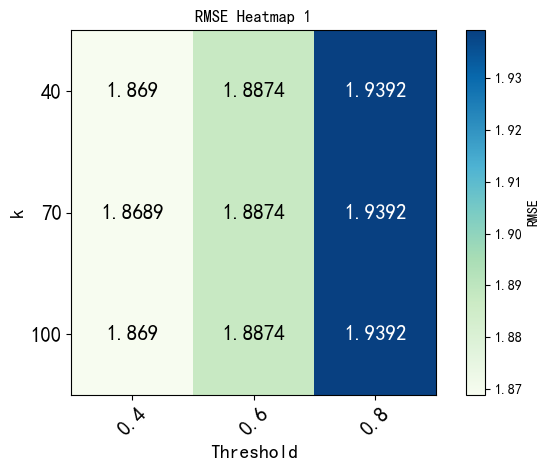

In [56]:
# 设置 k 值和 threshold 值
k_values, threshold_values, rmse_results = read_grid('rmse1.csv')

draw_confusion_matrix(rmse_results,
                      label_x = threshold_values,
                      label_y = k_values,
                      title="RMSE Heatmap 1",
                      pdf_save_path="Confusion_Matrix_1.png",
                      dpi=300,
                      threshold = 1.90)

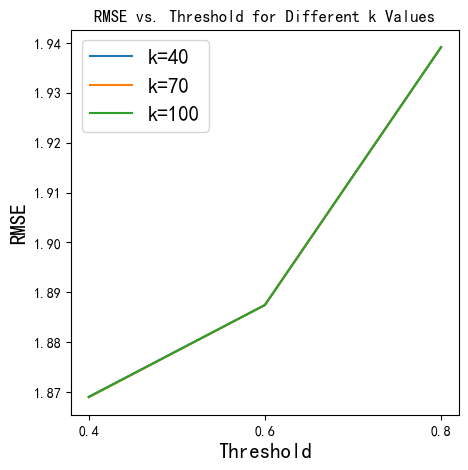

In [57]:
draw_line(k_values, threshold_values, rmse_results, save_path="Lines_1.png")

##### exp2

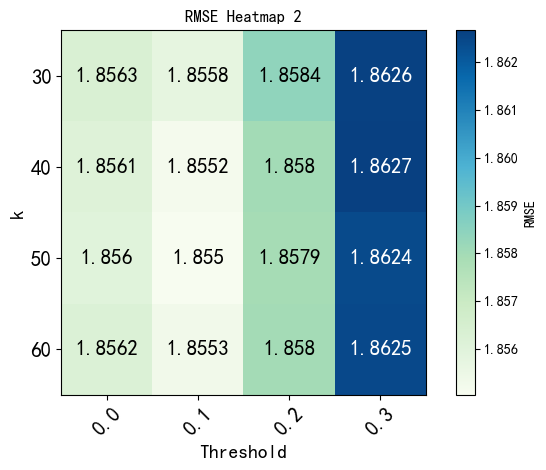

In [58]:
# 设置 k 值和 threshold 值
k_values, threshold_values, rmse_results = read_grid('rmse2.csv')

draw_confusion_matrix(rmse_results,
                      label_x = threshold_values,
                      label_y = k_values,
                      title="RMSE Heatmap 2",
                      pdf_save_path="Confusion_Matrix_2.png",
                      dpi=300,
                      threshold = 1.859)

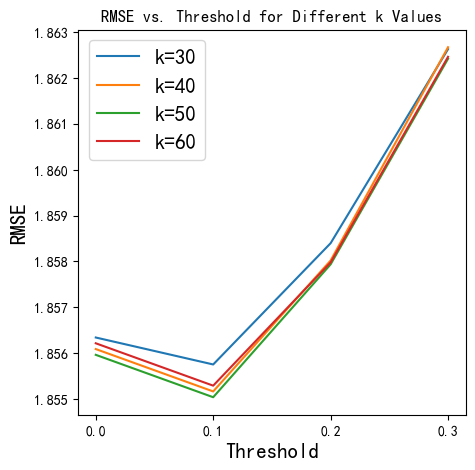

In [59]:
draw_line(k_values, threshold_values, rmse_results, save_path="Lines_2.png")

##### exp3

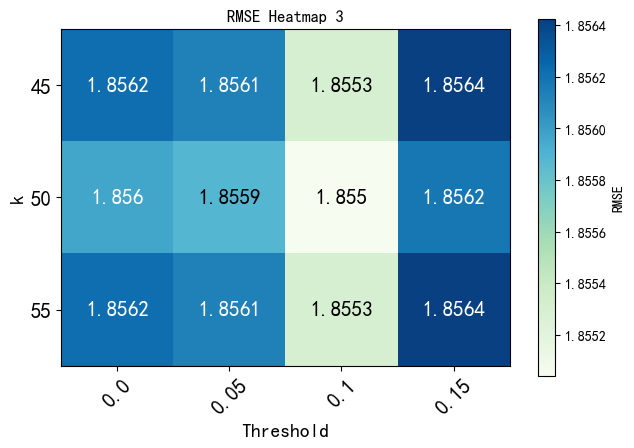

In [64]:
# 设置 k 值和 threshold 值
k_values, threshold_values, rmse_results = read_grid('rmse3.csv')

draw_confusion_matrix(rmse_results,
                      label_x = threshold_values,
                      label_y = k_values,
                      title="RMSE Heatmap 3",
                      pdf_save_path="Confusion_Matrix_3.png",
                      dpi=300,
                      threshold = 1.8560)

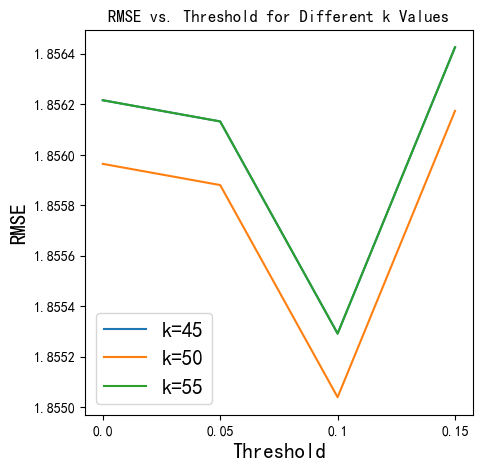

In [61]:
draw_line(k_values, threshold_values, rmse_results, save_path="Lines_3.png")

##### exp4

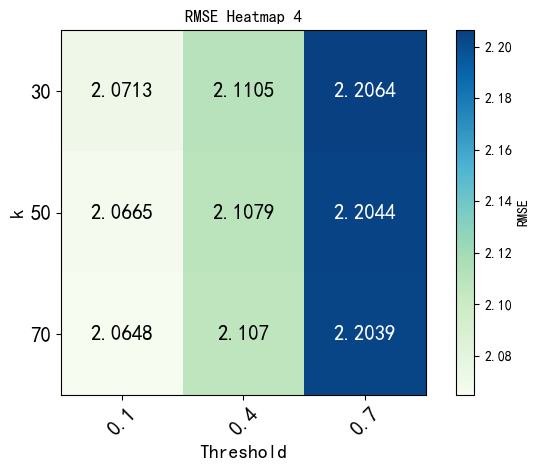

In [62]:
# 设置 k 值和 threshold 值
k_values, threshold_values, rmse_results = read_grid('rmse4.csv')

draw_confusion_matrix(rmse_results,
                      label_x = threshold_values,
                      label_y = k_values,
                      title="RMSE Heatmap 4",
                      pdf_save_path="Confusion_Matrix_4.png",
                      dpi=300,
                      threshold = 2.2)

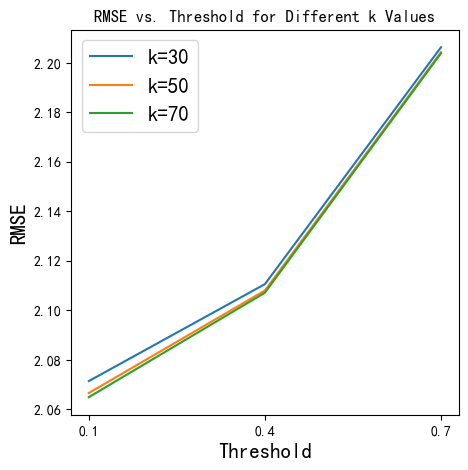

In [63]:
draw_line(k_values, threshold_values, rmse_results, save_path="Lines_4.png")

### 输出结果

In [12]:
# 读入数据
train_path = "train.csv"
test_path = "test.csv"
test_size = 0.2
random_state = 42

# 划分数据
train_df, testset = load_and_split(train_path, test_path, test_size, random_state, choice = 1)

# 设定参数
k = 50
threshold = 0.1

# 计算一些后续要用到的东西
train_mean = train_df.mean(axis = 1, skipna = True)
train_sim = pearson_sim_matrix(train_df)

In [13]:
def predict_rates(row):
  # 对每一行调用predict_rate
  pred = predict_rate(train_df, row["userid"], row["itemid"], k, threshold, train_mean, train_sim)
  return pred

def predict_testset(testset):  
  # 对每一行进行预测
  testset['rate'] = testset.apply(predict_rates, axis=1)
  # 存储为符合要求的数据框和csv
  result = testset["rate"].to_frame(name="rate")
  result.insert(0, "idx", result.index)
  result.to_csv("output_2.csv",index = False,header=True)
  return result

In [14]:
result = predict_testset(testset)
result

,idx,rate
0,0,8
1,1,7
2,2,7
3,3,8
4,4,6
...,...,...
5672,5672,7
5673,5673,7
5674,5674,9
5675,5675,9
